In [1]:
from pyspark import SparkContext
import json
import csv
import ast
import re
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
output_file_path = "/Users/liangsiqi/Documents/Dataset/inf553final_competition/val_pred.csv"
test_file_path = "/Users/liangsiqi/Documents/Dataset/inf553final_competition/yelp_val.csv"

In [3]:
path = "/Users/liangsiqi/Documents/Dataset/inf553final_competition/"
business_file_name = "business.json"
review_train_file_name = "review_train.json"
user_file_name = "user.json"

In [4]:
def print_dict(d):
    for i in d:
        print("{0} : {1}".format(i,d[i]))

def user_extract(x):
    user_id = x['user_id']
    review_cnt = x['review_count']
    if x['friends'] == 'None':
        friends = 0
    else:
        friends = len(x['friends'])
        
    useful = x['useful']
    cool = x['cool']
    funny = x['funny']
    fans = x['fans']
    avg_star = x['average_stars']
    # user_id, review_cnt, friends, useful, cool, funny, fans, avg_star
    return (user_id, review_cnt, friends, useful, cool, funny, fans, avg_star)
    
def get_duration(string):
    tmp = re.split('[\-:]+',string)
    duration = float(int(tmp[2]) - int(tmp[0]))
    if duration < 0:
        duration += 24
    return duration
    
def business_extract(x):
    bid = x['business_id']
    state = x['state']
    latitude = x['latitude']
    longitude = x['longitude']
    star = x['stars']
    review_cnt = x['review_count']
    if x['categories'] is None:
        categories = []
    else:
        categories = sorted(x['categories'].split(', '))
        
    if x['hours'] is None:
        duration = -1
        mon = -1
        tue = -1
        wed = -1
        thu = -1
        fri = -1
        sat = -1
        sun = -1
    else:
        duration = len(x['hours'])
        hours = x['hours']
        if 'Monday' in hours:
            mon = get_duration(hours['Monday'])
        else:
            mon = 0
        if 'Tuesday' in hours:
            tue = get_duration(hours['Tuesday'])
        else:
            tue = 0
        if 'Wednesday' in hours:
            wed = get_duration(hours['Wednesday'])
        else:
            wed = 0
        if 'Thursday' in hours:
            thu = get_duration(hours['Thursday'])
        else:
            thu = 0
        if 'Friday' in hours:
            fri = get_duration(hours['Friday'])
        else:
            fri = 0
        if 'Saturday' in hours:
            sat = get_duration(hours['Saturday'])
        else:
            sat = 0
        if 'Sunday' in hours:
            sun = get_duration(hours['Sunday'])
        else:
            sun = 0 
    
    BikeParking = 0
    NoiseLevel = -1
    GoodForKids = -1
    BusinessParking = -1
    
    RestaurantsPriceRange = -1
    if isinstance(x['attributes'],dict):
        attribute = x['attributes']
        if 'BikeParking' in attribute:
            if attribute['BikeParking'] == 'True':
                BikeParking = 1
        if 'NoiseLevel' in attribute:
            NoiseLevel = attribute['NoiseLevel']    
        if 'RestaurantsPriceRange2' in attribute:
            RestaurantsPriceRange = int(attribute['RestaurantsPriceRange2'])       
        if 'GoodForKids' in attribute:
            if attribute['GoodForKids'] == 'True':
                GoodForKids = 1
            if attribute['GoodForKids'] == 'False':
                GoodForKids = 0
        if 'BusinessParking' in attribute:
            acceptable_string = attribute['BusinessParking'].replace("'", "\"")
            BusinessParking_dict = ast.literal_eval(acceptable_string) 
            if any(list(BusinessParking_dict.values())):
                BusinessParking = 1
            else:
                BusinessParking = 0
            
    # bid, state, star, latitude, longitude, review_cnt, BikeParking, BusinessParking, NoiseLevel, GoodForKids, categories, duration, mon, tue, wed, thu, fri, sat, sun
    return (bid, state, star, latitude, longitude, review_cnt, BikeParking, BusinessParking, NoiseLevel, GoodForKids, categories, duration, mon, tue, wed, thu, fri, sat, sun)    



In [5]:
sc = SparkContext.getOrCreate()

In [6]:
userRDD = sc.textFile(path + user_file_name).map(json.loads)
businessRDD = sc.textFile(path + business_file_name).map(json.loads)
review_train_RDD = sc.textFile(path + review_train_file_name).map(json.loads)

# ``user.json`` extraction

In [7]:
print("User sample:")
print_dict(userRDD.take(1)[0])

User sample:
user_id : lzlZwIpuSWXEnNS91wxjHw
name : Susan
review_count : 1
yelping_since : 2015-09-28
friends : None
useful : 0
funny : 0
cool : 0
fans : 0
elite : None
average_stars : 2.0
compliment_hot : 0
compliment_more : 0
compliment_profile : 0
compliment_cute : 0
compliment_list : 0
compliment_note : 0
compliment_plain : 0
compliment_cool : 0
compliment_funny : 0
compliment_writer : 0
compliment_photos : 0


In [9]:
user_profile = userRDD.map(user_extract)
user_profile.take(3)

[('lzlZwIpuSWXEnNS91wxjHw', 1, 0, 0, 0, 0, 0, 2.0),
 ('XvLBr-9smbI0m_a7dXtB7w', 2, 0, 0, 0, 0, 0, 5.0),
 ('QPT4Ud4H5sJVr68yXhoWFw', 1, 0, 0, 0, 0, 0, 4.0)]

In [13]:
user_profile_data = user_profile.collect()
user_profile_df = pd.DataFrame(data=user_profile.collect(),
                               columns=['user_id', 'review_cnt', 
                                       'friends', 'useful', 'cool', 
                                       'funny', 'fans', 'avg_star'])

user_profile_df.to_csv("../data/user_feature.csv",index=False)

# ``business.json`` extraction

In [7]:
print("\nBusiness sample:")
print_dict(businessRDD.take(1)[0])


Business sample:
business_id : Apn5Q_b6Nz61Tq4XzPdf9A
name : Minhas Micro Brewery
neighborhood : 
address : 1314 44 Avenue NE
city : Calgary
state : AB
postal_code : T2E 6L6
latitude : 51.0918130155
longitude : -114.031674872
stars : 4.0
review_count : 24
is_open : 1
attributes : {'BikeParking': 'False', 'BusinessAcceptsCreditCards': 'True', 'BusinessParking': "{'garage': False, 'street': True, 'validated': False, 'lot': False, 'valet': False}", 'GoodForKids': 'True', 'HasTV': 'True', 'NoiseLevel': 'average', 'OutdoorSeating': 'False', 'RestaurantsAttire': 'casual', 'RestaurantsDelivery': 'False', 'RestaurantsGoodForGroups': 'True', 'RestaurantsPriceRange2': '2', 'RestaurantsReservations': 'True', 'RestaurantsTakeOut': 'True'}
categories : Tours, Breweries, Pizza, Restaurants, Food, Hotels & Travel
hours : {'Monday': '8:30-17:0', 'Tuesday': '11:0-21:0', 'Wednesday': '11:0-21:0', 'Thursday': '11:0-21:0', 'Friday': '11:0-21:0', 'Saturday': '11:0-21:0'}


In [8]:
min_bisiness_feat = businessRDD.map(lambda x: (1, set(list(x.keys())))).reduceByKey(lambda a,b: a.intersection(b)).collect()[0][1]
max_bisiness_feat = businessRDD.map(lambda x: (1, set(list(x.keys())))).reduceByKey(lambda a,b: a.union(b)).collect()[0][1]
print("Business minimum info:",min_bisiness_feat)
print("Business maximum info:",max_bisiness_feat)

Business minimum info: {'state', 'review_count', 'city', 'attributes', 'latitude', 'categories', 'stars', 'longitude', 'is_open', 'postal_code', 'neighborhood', 'name', 'address', 'business_id', 'hours'}
Business maximum info: {'state', 'review_count', 'city', 'attributes', 'latitude', 'categories', 'stars', 'longitude', 'is_open', 'postal_code', 'neighborhood', 'name', 'address', 'business_id', 'hours'}


In [9]:
business_profile = businessRDD.map(lambda x: business_extract(x))
business_profile_data = business_profile.collect()
business_profile_df = pd.DataFrame(data=business_profile_data,
                                   columns=['business_id', 'state', 'star', 
                                            'latitude', 'longitude', 'review_cnt', 
                                            'BikeParking', 'BusinessParking', 
                                            'NoiseLevel', 'GoodForKids', 'categories', 
                                            'duration', 'mon', 'tue', 'wed', 'thu', 
                                            'fri', 'sat', 'sun'])

business_profile_df.head()

,business_id,state,star,latitude,longitude,review_cnt,BikeParking,BusinessParking,NoiseLevel,GoodForKids,categories,duration,mon,tue,wed,thu,fri,sat,sun
0,Apn5Q_b6Nz61Tq4XzPdf9A,AB,4.0,51.091813,-114.031675,24,0,1,average,1,"[Breweries, Food, Hotels & Travel, Pizza, Rest...",6,9.0,10.0,10.0,10.0,10.0,10.0,0.0
1,AjEbIBw6ZFfln7ePHha9PA,NV,4.5,35.960734,-114.939821,3,0,1,-1,1,"[Barbeque, Burgers, Caterers, Chicken Wings, E...",3,0.0,0.0,0.0,0.0,6.0,6.0,6.0
2,O8S5hYJ1SMc8fA4QBtVujA,QC,4.0,45.540503,-73.599300,5,1,0,average,1,"[Breakfast & Brunch, Cafes, French, Restaurant...",7,12.0,12.0,12.0,12.0,12.0,12.0,12.0
3,bFzdJJ3wp3PZssNEsyU23g,AZ,1.5,33.449999,-112.076979,8,0,-1,-1,-1,"[Financial Services, Insurance]",-1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,8USyCYqpScwiNEb58Bt6CA,AB,2.0,51.035591,-114.027366,4,0,-1,-1,-1,"[Automotive, Electronics Repair, Home & Garden...",5,9.0,9.0,9.0,9.0,9.0,0.0,0.0


In [10]:
business_profile_df.to_csv("../data/business_features.csv",index=False)

# ``review_train.json`` extraction

In [15]:
print("\nReview sample:")
print_dict(review_train_RDD.take(1)[0])


Review sample:
review_id : D2TcNaPqXxDGQ6T0n-vHXw
user_id : YHWsLBS8jzZiPjKHMFOaAA
business_id : iKMLsX1Je7P3wAOEc9scDg
stars : 4.0
date : 2011-11-07
text : I have been itching to get to Origin for months now after a friend of mine had gone and raved about the food. I dug the concept: tapas with a twist. This is definitely not your traditional, Spanish tapas. At Origin, you'll sample small plates with Asian, Italian and Latin influences. I didn't find the menu overwhelming, but our server was more than happy to help steer the meal so that similar and complimentary flavours were eaten together.

It was tough to narrow it down, as we would have been happy with just about anything on the menu. We started with the tostones: smashed, flattened and deep-fried plantains with guacamole on the side. The plantains were very well seasoned, with generous use of kosher salt and a light dusting of curry powder.

Next up were the deviled eggs with smoked bacon and gremolata and the smoked cod croque

# Check user features

In [21]:
user_features = pd.read_csv("../data/user_feature.csv")
user_features.head()

,user_id,review_cnt,friends,useful,cool,funny,fans,avg_star
0,lzlZwIpuSWXEnNS91wxjHw,1,0,0,0,0,0,2.00
1,XvLBr-9smbI0m_a7dXtB7w,2,0,0,0,0,0,5.00
2,QPT4Ud4H5sJVr68yXhoWFw,1,0,0,0,0,0,4.00
3,i5YitlHZpf0B3R0s_8NVuw,19,0,0,0,0,0,4.05
4,s4FoIXE_LSGviTHBe8dmcg,3,0,0,0,0,0,3.00


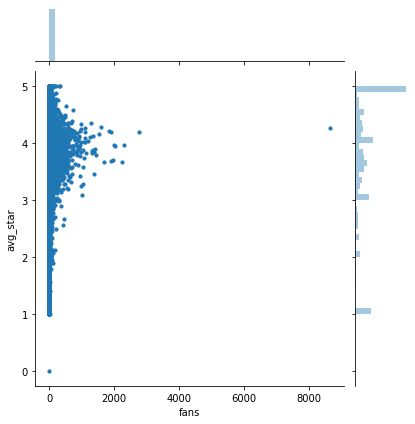

In [25]:
sns.jointplot(x="fans", y="avg_star", data=user_features, s=10)

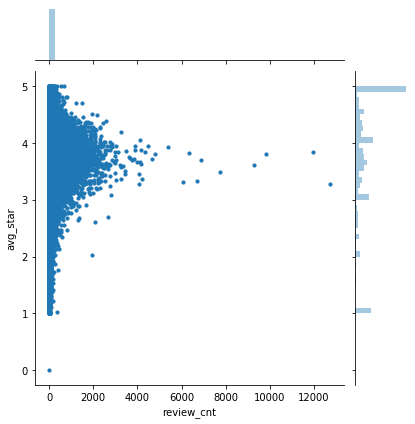

In [24]:
sns.jointplot(x="review_cnt", y="avg_star", data=user_features, s=10)

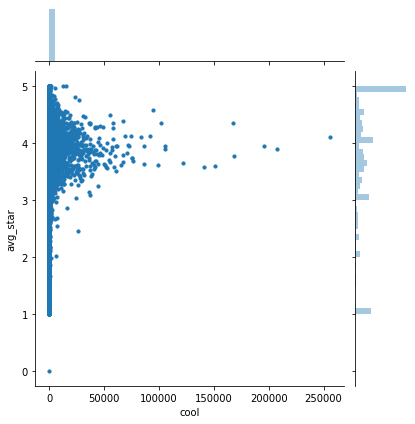

In [26]:
sns.jointplot(x="cool", y="avg_star", data=user_features, s=10)

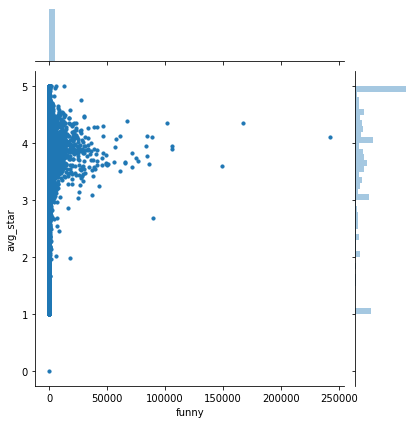

In [27]:
sns.jointplot(x="funny", y="avg_star", data=user_features, s=10)

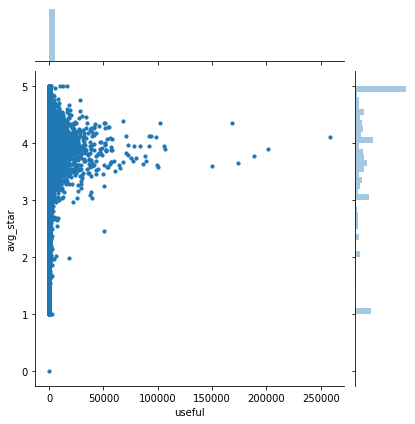

In [28]:
sns.jointplot(x="useful", y="avg_star", data=user_features, s=10)

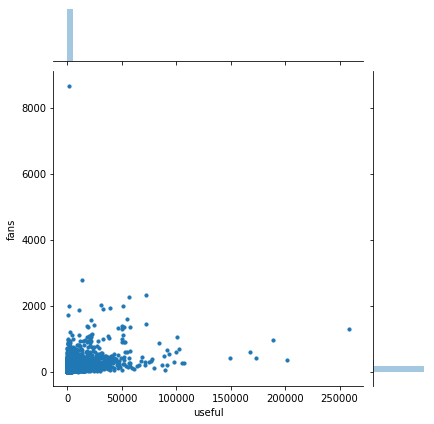

In [29]:
sns.jointplot(x="useful", y="fans", data=user_features, s=10)

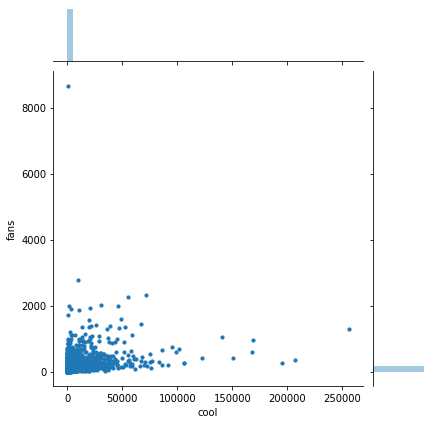

In [30]:
sns.jointplot(x="cool", y="fans", data=user_features, s=10)

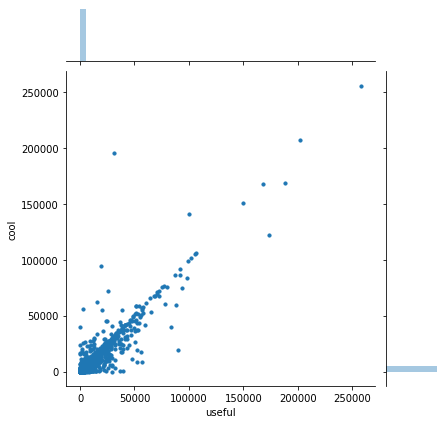

In [31]:
sns.jointplot(x="useful", y="cool", data=user_features, s=10)

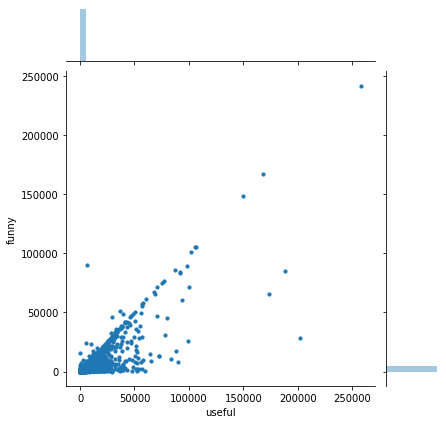

In [34]:
sns.jointplot(x="useful", y="funny", data=user_features, s=10)

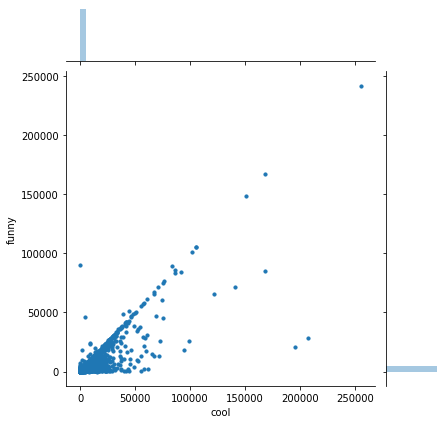

In [35]:
sns.jointplot(x="cool", y="funny", data=user_features, s=10)

# Business Features

In [11]:
business_features = pd.read_csv("../data/business_features.csv")

In [12]:
business_features.head()

,business_id,state,star,latitude,longitude,review_cnt,BikeParking,BusinessParking,NoiseLevel,GoodForKids,categories,duration,mon,tue,wed,thu,fri,sat,sun
0,Apn5Q_b6Nz61Tq4XzPdf9A,AB,4.0,51.091813,-114.031675,24,0,1,average,1,"['Breweries', 'Food', 'Hotels & Travel', 'Pizz...",6,9.0,10.0,10.0,10.0,10.0,10.0,0.0
1,AjEbIBw6ZFfln7ePHha9PA,NV,4.5,35.960734,-114.939821,3,0,1,-1,1,"['Barbeque', 'Burgers', 'Caterers', 'Chicken W...",3,0.0,0.0,0.0,0.0,6.0,6.0,6.0
2,O8S5hYJ1SMc8fA4QBtVujA,QC,4.0,45.540503,-73.599300,5,1,0,average,1,"['Breakfast & Brunch', 'Cafes', 'French', 'Res...",7,12.0,12.0,12.0,12.0,12.0,12.0,12.0
3,bFzdJJ3wp3PZssNEsyU23g,AZ,1.5,33.449999,-112.076979,8,0,-1,-1,-1,"['Financial Services', 'Insurance']",-1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,8USyCYqpScwiNEb58Bt6CA,AB,2.0,51.035591,-114.027366,4,0,-1,-1,-1,"['Automotive', 'Electronics Repair', 'Home & G...",5,9.0,9.0,9.0,9.0,9.0,0.0,0.0


In [13]:
business_features.describe()

,star,latitude,longitude,review_cnt,BikeParking,BusinessParking,GoodForKids,duration,mon,tue,wed,thu,fri,sat,sun
count,188593.000000,188587.000000,188587.000000,188593.000000,188593.000000,188593.000000,188593.000000,188593.000000,188593.000000,188593.000000,188593.00000,188593.000000,188593.000000,188593.000000,188593.000000
mean,3.631550,38.506793,-97.490873,31.797310,0.350692,-0.131521,-0.376679,4.630750,6.625967,6.991723,7.04454,7.121542,7.132306,5.874661,4.011077
std,1.016783,5.122684,17.693360,104.124212,0.477188,0.868556,0.890424,3.238593,5.769912,5.636014,5.61221,5.636879,5.730767,5.827760,5.538431
min,1.000000,-71.753941,-180.000000,3.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000
25%,3.000000,33.630878,-112.279276,4.000000,0.000000,-1.000000,-1.000000,4.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
50%,3.500000,36.143595,-111.777460,9.000000,0.000000,0.000000,-1.000000,6.000000,9.000000,9.000000,9.00000,9.000000,9.000000,7.000000,0.000000
75%,4.500000,43.593106,-79.982958,24.000000,1.000000,1.000000,1.000000,7.000000,11.000000,11.000000,11.00000,11.000000,11.000000,11.000000,9.000000
max,5.000000,85.051129,115.086769,7968.000000,1.000000,1.000000,1.000000,7.000000,23.000000,23.000000,23.00000,23.000000,23.000000,23.000000,23.000000


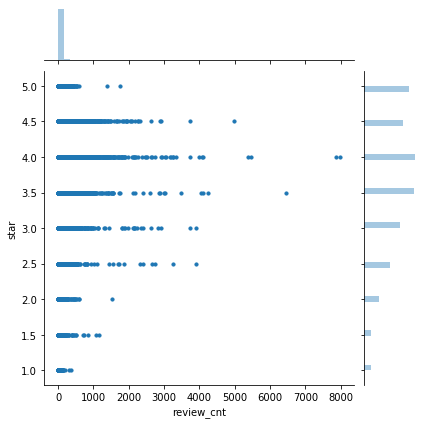

In [18]:
sns.jointplot(x="review_cnt", y="star", data=business_features, s=10)

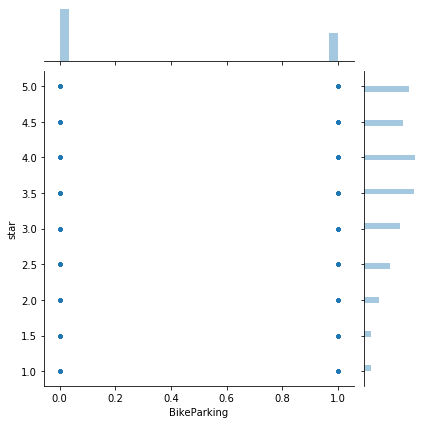

In [19]:
sns.jointplot(x="BikeParking", y="star", data=business_features, s=10)

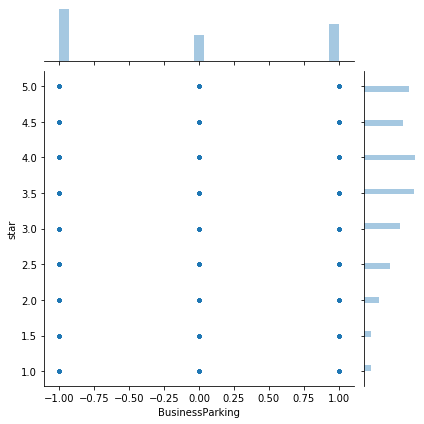

In [20]:
sns.jointplot(x="BusinessParking", y="star", data=business_features, s=10)

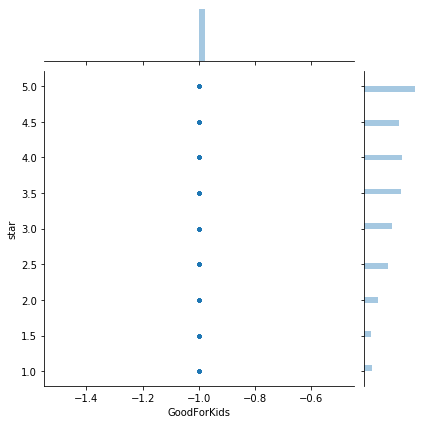

In [22]:
sns.jointplot(x="GoodForKids", y="star", data=business_features[business_features["GoodForKids"]==-1], s=10)

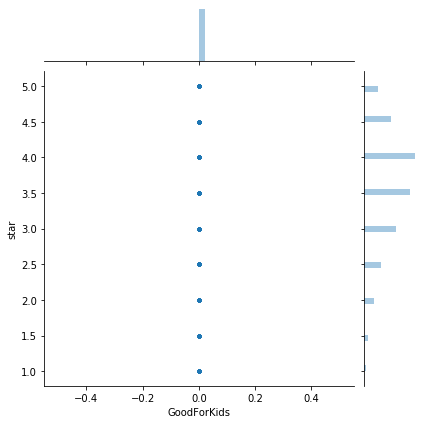

In [23]:
sns.jointplot(x="GoodForKids", y="star", data=business_features[business_features["GoodForKids"]==0], s=10)

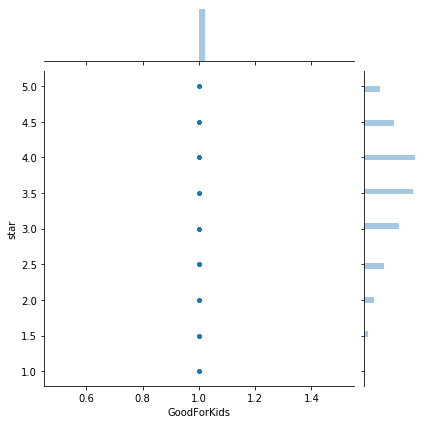

In [24]:
sns.jointplot(x="GoodForKids", y="star", data=business_features[business_features["GoodForKids"]==1], s=10)

## Business Duration & Stars

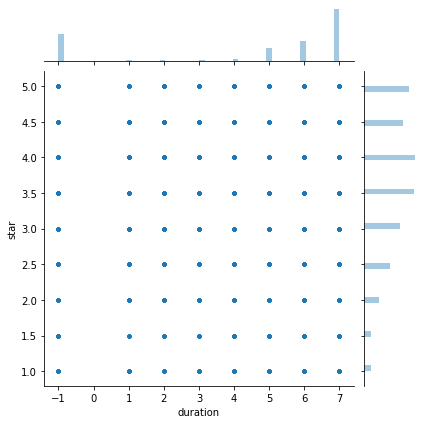

In [25]:
sns.jointplot(x="duration", y="star", data=business_features, s=10)

In [29]:
business_features['duration'].value_counts()

 7    86378
-1    44802
 6    32201
 5    21758
 4     2152
 3      614
 2      349
 1      339
Name: duration, dtype: int64

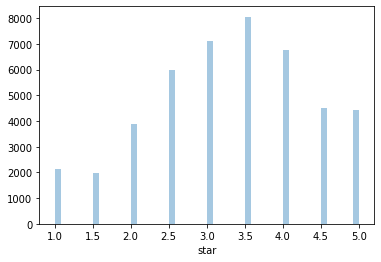

In [37]:
# duration = -1
sns.distplot(business_features[business_features['duration']==-1]['star'],kde=False)

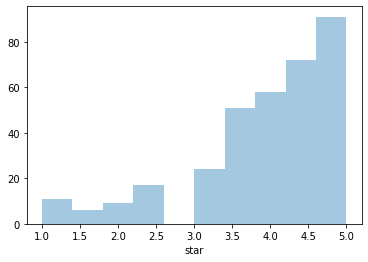

In [38]:
# duration = 1
sns.distplot(business_features[business_features['duration']==1]['star'],kde=False)

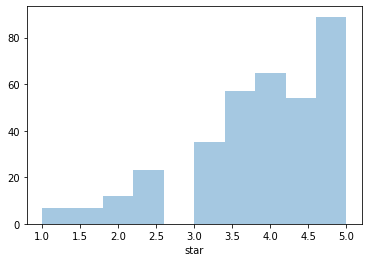

In [39]:
# duration = 2
sns.distplot(business_features[business_features['duration']==2]['star'],kde=False)

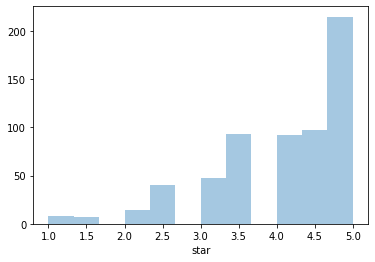

In [40]:
# duration = 3
sns.distplot(business_features[business_features['duration']==3]['star'],kde=False)

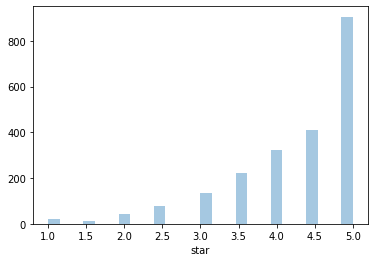

In [41]:
# duration = 4
sns.distplot(business_features[business_features['duration']==4]['star'],kde=False)

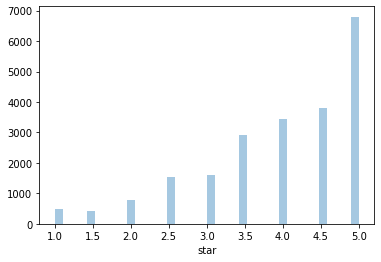

In [42]:
# duration = 5
sns.distplot(business_features[business_features['duration']==5]['star'],kde=False)

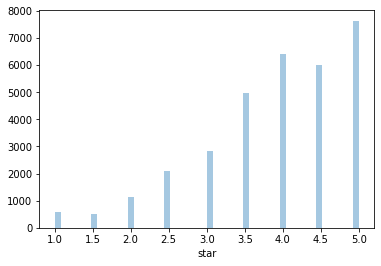

In [43]:
# duration = 6
sns.distplot(business_features[business_features['duration']==6]['star'],kde=False)

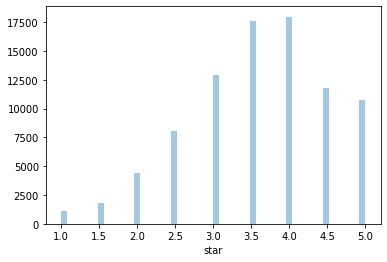

In [44]:
# duration = 7
sns.distplot(business_features[business_features['duration']==7]['star'],kde=False)

## Weekend Hours

In [46]:
business_features['sat'].value_counts()

-1.0     44802
 0.0     27288
 8.0     13688
 9.0     13158
 11.0    12871
 12.0    12614
 10.0    12214
 7.0      8903
 6.0      6747
 13.0     5951
 5.0      5553
 14.0     5075
 15.0     4977
 4.0      4706
 16.0     3019
 3.0      1827
 17.0     1654
 18.0     1310
 19.0      656
 2.0       522
 20.0      331
 23.0      295
 1.0       215
 21.0      138
 22.0       79
Name: sat, dtype: int64

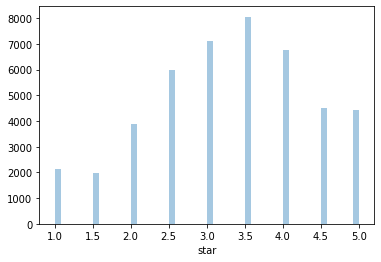

In [45]:
sns.distplot(business_features[business_features['sat']==-1]['star'],kde=False)

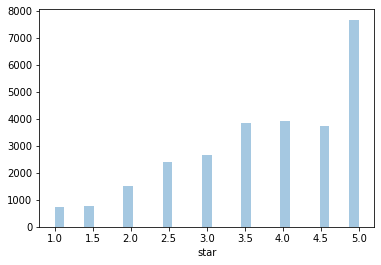

In [47]:
sns.distplot(business_features[business_features['sat']==0]['star'],kde=False)

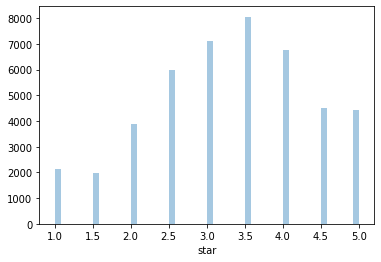

In [50]:
sns.distplot(business_features[business_features['sun']==-1]['star'],kde=False)

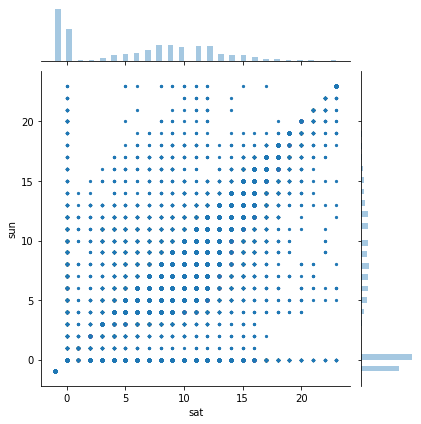

In [56]:
sns.jointplot(x="sat", y="sun", data=business_features, s=5)

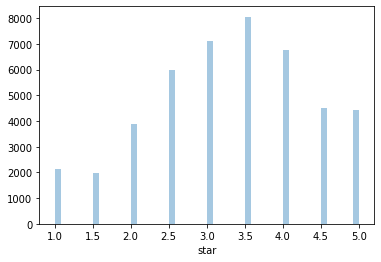

In [58]:
sns.distplot(business_features[business_features['sat']==-1]['star'],kde=False)

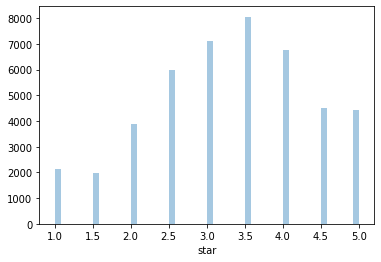

In [59]:
sns.distplot(business_features[business_features['sun']==-1]['star'],kde=False)

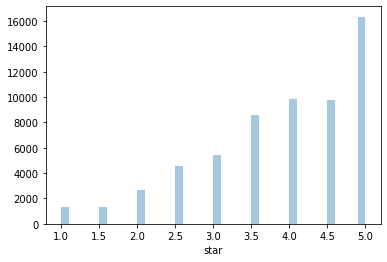

In [60]:
sns.distplot(business_features[business_features['sun']==0]['star'],kde=False)

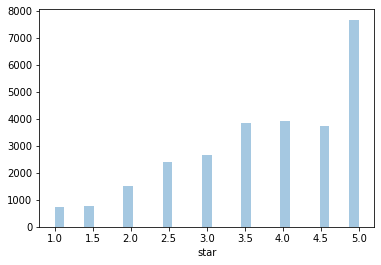

In [61]:
sns.distplot(business_features[business_features['sat']==0]['star'],kde=False)

## NoiseLevel

In [76]:
business_features["NoiseLevel"].value_counts()

-1           144883
average       28219
quiet          9651
loud           4082
very_loud      1758
Name: NoiseLevel, dtype: int64

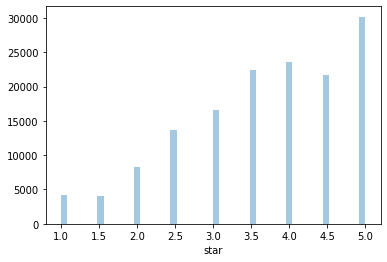

In [84]:
sns.distplot(business_features[business_features['NoiseLevel']=='-1']['star'],kde=False)

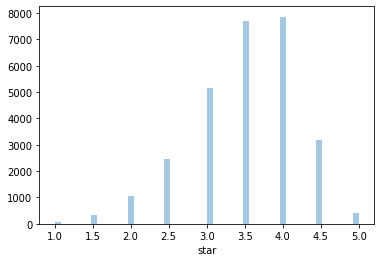

In [80]:
sns.distplot(business_features[business_features['NoiseLevel']=='average']['star'],kde=False)

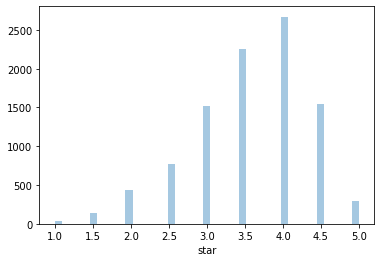

In [86]:
sns.distplot(business_features[business_features['NoiseLevel']=='quiet']['star'],kde=False)

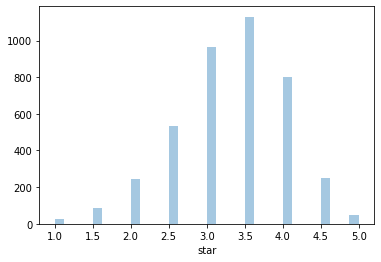

In [87]:
sns.distplot(business_features[business_features['NoiseLevel']=='loud']['star'],kde=False)

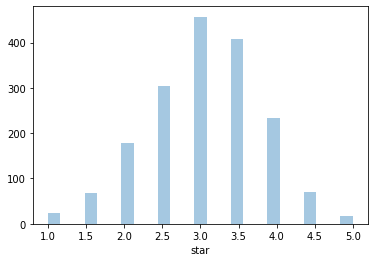

In [88]:
sns.distplot(business_features[business_features['NoiseLevel']=='very_loud']['star'],kde=False)